# Start from simple

Zero padding requires:
- 0 only represent the position holder (missing value in our case);
- The none zero values (observed) usually have at least 10% out of all observations;

Convert all 36 weeks into 5 different collection periods and taking the within period mean of each covariates (both time varying and not-varying)
- Largely reduce the number of padded zeros;
- Solves the issues that there are multiple collections in the same week;
- Maybe no need to do the label smoothing since only 4 or 5 labels per patient;

In [1]:
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import sklearn as sk

# from torch.autograd import Variable 

from itertools import islice
from sklearn import metrics
from sklearn import preprocessing

from collections import Counter,defaultdict, OrderedDict

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

# 1. Read-in & clean data.

In [3]:
# data directory
# alpha_dir     = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/training_data_2022-05-27/alpha_diversity/alpha_diversity.csv'
# cst_dir       = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/training_data_2022-05-27/community_state_types/cst_valencia.csv'
meta_dir      = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/metadata_imputed1.csv'
# krdlong_dir   = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/training_data_2022-05-27/pairwise_distance/krd_distance_long.csv'
# krdwide_dir   = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/training_data_2022-05-27/pairwise_distance/krd_distance_wide.csv'
phylotype_dir = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/training_data_2022-05-27/phylotypes/phylotype_relabd.1e0.csv'
taxonomy_dir  = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/training_data_2022-05-27/taxonomy/taxonomy_relabd.family.csv'

## Meta data

In [4]:
meta_data = pd.DataFrame(pd.read_csv(meta_dir, delimiter=','))
meta_data = meta_data[['participant_id', 'project', 'delivery_wk', 'collect_wk', 'age_imp', 'race_imp']]

print(meta_data.shape)

for i in range(1,meta_data.shape[1]):
    if meta_data.iloc[:,i].dtypes == object:
        meta_data.iloc[:,i] = meta_data.iloc[:,i].astype('category').cat.codes + 1
        meta_data.iloc[:,i] = meta_data.iloc[:,i].astype('float64')

# create new variable collection period
meta_data['collect_period'] = 1
meta_data['collect_period'][(meta_data['collect_wk']>=9)  & (meta_data['collect_wk']<=16)] = 2
meta_data['collect_period'][(meta_data['collect_wk']>=17) & (meta_data['collect_wk']<=24)] = 3
meta_data['collect_period'][(meta_data['collect_wk']>=25) & (meta_data['collect_wk']<=32)] = 4
meta_data['collect_period'][(meta_data['collect_wk']>32)]                                  = 5

collect_period = meta_data['collect_period']
participant_id = meta_data['participant_id']

# create class label
meta_data['was_preterm'] = 1*(meta_data['delivery_wk'] < 37)
meta_data['was_early_preterm'] = 1*(meta_data['delivery_wk'] < 32)

# number of patient
unique, counts = np.unique(meta_data['participant_id'], return_counts=True)
print(len(unique))

(3578, 6)
1268


/var/folders/xy/ccg9zpjj4sq_l6d6fypc_5740000gn/T/ipykernel_96898/973294587.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['collect_period'][(meta_data['collect_wk']>=9)  & (meta_data['collect_wk']<=16)] = 2
/var/folders/xy/ccg9zpjj4sq_l6d6fypc_5740000gn/T/ipykernel_96898/973294587.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['collect_period'][(meta_data['collect_wk']>=17) & (meta_data['collect_wk']<=24)] = 3
/var/folders/xy/ccg9zpjj4sq_l6d6fypc_5740000gn/T/ipykernel_96898/973294587.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

- Filtered out observations with collect_wk<=32;
- Average within each collection period;

In [5]:
# Filtered out observations with "collect_wk<=32" == "collect_period<=4" 
meta_data = meta_data[meta_data['collect_period']<=4]
# Average within each collection period
meta_data = meta_data.groupby(['participant_id', 'collect_period'], as_index = False).mean()
print(meta_data.shape)

(1582, 9)


## Taxonomy OTU (RA) data (Family level)
- Filtered out observations with collect_wk<=32;
- Average within each collection period;

In [6]:
taxonomy_data = pd.DataFrame(pd.read_csv(taxonomy_dir, delimiter=','))
taxonomy_data = pd.concat([participant_id, collect_period, taxonomy_data], axis=1)

# Filtered out observations with "collect_wk<=32" == "collect_period<=4" 
taxonomy_data = taxonomy_data[taxonomy_data['collect_period']<=4]
# Average within each collection period
taxonomy_data = taxonomy_data.groupby(['participant_id', 'collect_period'], as_index = False).mean()
print(taxonomy_data.shape)

# # delete the temporary filter-used and ID columns
# taxonomy_data = taxonomy_data.drop(["participant_id", "collect_period"], axis = 1)

(1582, 527)


## Phylotype data
- Filtered out observations with collect_wk<=32;
- Average within each collection period;

In [7]:
phylotype_data = pd.DataFrame(pd.read_csv(phylotype_dir, delimiter=','))
phylotype_data = pd.concat([participant_id, collect_period, phylotype_data], axis=1)

# Filtered out observations with "collect_wk<=32" == "collect_period<=4" 
phylotype_data = phylotype_data[phylotype_data['collect_period']<=4]
# Average within each collection period
phylotype_data = phylotype_data.groupby(['participant_id', 'collect_period'], as_index = False).mean()
print(phylotype_data.shape)

# # delete the temporary filter-used and ID columns
# phylotype_data = phylotype_data.drop(["participant_id", "collect_period"], axis = 1)

(1582, 1846)


## Other Datasets (...)
- Filtered out observations with collect_wk<=32;
- Average within each collection period;

In [8]:
# 

## Dimension Summary

In [9]:
uniquenames, counts = np.unique(meta_data["participant_id"], return_counts=True)
subjects = list(uniquenames)
seq_max_len = max(counts)

print("# of subjects = ", len(subjects))
print("# of samples  = ", meta_data.shape[0])
print("# of taxonnomy features = ", len(list(taxonomy_data)))
print("# of phylotype features = ", len(list(phylotype_data)))

# of subjects =  1214
# of samples  =  1582
# of taxonnomy features =  527
# of phylotype features =  1846


# 2. Data sets splitter

Since we have multiple datasets, we will use Index of subjects to guide training, validation and testing set spliter. Also note, Since there are different number of records for each patient, the dimension of train and testing data sets are not follow the proportion 0.8, but the patients will follow.

In [10]:
def dataset_splitID(meta_data, subjects, prop, myseed):
    
    if myseed != None:
        random.seed(myseed)
        
    numsubjects = len(subjects)

    subjects_shuffle = random.sample(subjects, numsubjects)
    
    train_subjects = subjects_shuffle[0:(int(len(subjects)*prop[0])+1)] 
    valid_subjects = subjects_shuffle[(int(len(subjects)*prop[0])+2):(int(len(subjects)*(prop[0]+prop[1]))+1)]
    test_subjects = subjects_shuffle[(int(len(subjects)*(prop[0]+prop[1]))+2):numsubjects]
    
    splitID_train = meta_data['participant_id'].isin(train_subjects)
    splitID_valid = meta_data['participant_id'].isin(valid_subjects)
    splitID_test = meta_data['participant_id'].isin(test_subjects)
    
    return splitID_train, splitID_valid, splitID_test

In [11]:
# set myseed=None to have complete random state
splitID_train, splitID_valid, splitID_test = dataset_splitID(meta_data, subjects, prop = [0.7, 0.2, 0.1], myseed=0)

# apply to each data sets
meta_data_train = meta_data[splitID_train]
meta_data_valid = meta_data[splitID_valid]
meta_data_test  = meta_data[splitID_test]

print(meta_data_train.shape)
print(meta_data_valid.shape)
print(meta_data_test.shape)

taxonomy_data_train = taxonomy_data[splitID_train]
taxonomy_data_valid = taxonomy_data[splitID_valid]
taxonomy_data_test  = taxonomy_data[splitID_test]

print(taxonomy_data_train.shape)
print(taxonomy_data_valid.shape)
print(taxonomy_data_test.shape)

phylotype_data_train = phylotype_data[splitID_train]
phylotype_data_valid = phylotype_data[splitID_valid]
phylotype_data_test  = phylotype_data[splitID_test]

print(phylotype_data_train.shape)
print(phylotype_data_valid.shape)
print(phylotype_data_test.shape)

# other data sets

(1098, 9)
(326, 9)
(156, 9)
(1098, 527)
(326, 527)
(156, 527)
(1098, 1846)
(326, 1846)
(156, 1846)


# 3. Data Reshaper

## Reshape Input

In [12]:
def Data_Reshaper_Input(data, seq_length):
    
    numsubjects = len(np.unique(data['participant_id']))
    myvary = list(data.columns.values)[2:data.shape[1]]
    num_covariates = len(myvary)
    
    myinput = np.zeros((numsubjects, seq_length, num_covariates), dtype=np.float32)
    for i in range(num_covariates):
        data_wide = data.pivot_table(index=['participant_id'], columns='collect_period', values=myvary[i])
        data_wide = data_wide.sort_index(axis=1)
        data_wide = data_wide.fillna(0)
        tmpindex = data_wide._get_numeric_data().columns.values - 1
        tmpindex = tmpindex.tolist()
        # time varying variables need to impute all and no records are denoted as 0
        for j in range(numsubjects):
                myinput[j,tmpindex,i] = data_wide.iloc[[j]]
    return myinput

**Warning**: *Longer running time*

In [13]:
taxonomytrain_input = Data_Reshaper_Input(data=taxonomy_data_train, seq_length=4)
print(taxonomytrain_input.shape)
taxonomyvalid_input = Data_Reshaper_Input(data=taxonomy_data_valid, seq_length=4)
print(taxonomyvalid_input.shape)
taxonomytest_input = Data_Reshaper_Input(data=taxonomy_data_test, seq_length=4)
print(taxonomytest_input.shape)

phylotypetrain_input = Data_Reshaper_Input(data=phylotype_data_train, seq_length=4)
print(phylotypetrain_input.shape)
phylotypevalid_input = Data_Reshaper_Input(data=phylotype_data_valid, seq_length=4)
print(phylotypevalid_input.shape)
phylotypetest_input = Data_Reshaper_Input(data=phylotype_data_test, seq_length=4)
print(phylotypetest_input.shape)

(850, 4, 525)
(242, 4, 525)
(120, 4, 525)
(850, 4, 1844)
(242, 4, 1844)
(120, 4, 1844)


## Reshape output

### Data_Reshaper_Output_ManytoMany_0

- reshape patients class labels from long to wide form;
- output array formulation, **two** columns;
- Label smoothing on FIRSTcolumn;
    - was_preterm: 0.5, 0.67, 0.83, 1;
    - not was_preterm: 0.5, 0.33, 0.17, 0;
    - no missing values;
- Label smoothing on Secondcolumn: 1 - FIRSTcolumn;

In [14]:
def Data_Reshaper_Output_ManytoMany_0(data, seq_length, classlabel):

    num_samples = len(np.unique(data['participant_id']))
    
    data_wide = data.pivot_table(index=['participant_id'], columns='collect_period', values=classlabel)
    data_wide = data_wide.sort_index(axis=1)
    
    myoutput = np.zeros((num_samples, seq_length, 2), dtype=np.float32)
    for i in range(num_samples):
        tmp = data_wide.iloc[i,:]
        
        if np.nanmax(tmp) == 1:
            # label linear smoonthing from 0.5 to 1
            # fill all position 1 to have final labels equal to 1
            myoutput[i,:,0].fill(1)
            myoutput[i,:,0] = np.linspace(start=0.5, stop=1, num=seq_length)
        else:
            # label linear smoonthing from 0.5 to 0
            # fill all position 0 to have final labels equal to 0 
            #     but array alrady initialize as 0
            myoutput[i,:,0] = np.linspace(start=0.5, stop=0, num=seq_length)
            
        myoutput[i,:,1] = 1 - myoutput[i,:,0]
    return myoutput

In [15]:
mytrain_output_0 = Data_Reshaper_Output_ManytoMany_0(data=meta_data_train, seq_length=4, classlabel="was_preterm")
print(mytrain_output_0.shape)
print(mytrain_output_0[2])

myvalid_output_0 = Data_Reshaper_Output_ManytoMany_0(data=meta_data_valid, seq_length=4, classlabel="was_preterm")
print(myvalid_output_0.shape)
print(myvalid_output_0[4])

mytest_output_0 = Data_Reshaper_Output_ManytoMany_0(data=meta_data_test, seq_length=4, classlabel="was_preterm")
print(mytest_output_0.shape)
print(mytest_output_0[4])

(850, 4, 2)
[[0.5        0.5       ]
 [0.33333334 0.6666666 ]
 [0.16666667 0.8333333 ]
 [0.         1.        ]]
(242, 4, 2)
[[0.5        0.5       ]
 [0.6666667  0.3333333 ]
 [0.8333333  0.16666669]
 [1.         0.        ]]
(120, 4, 2)
[[0.5        0.5       ]
 [0.6666667  0.3333333 ]
 [0.8333333  0.16666669]
 [1.         0.        ]]


# 4. Defining RNN model

Based on 4 different RNN output formation, we have 4 different RNN models.

In [16]:
class Model_0(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, seq_len, n_layers, fc_size):
        super(Model_0, self).__init__()

        # Defining some parameters
        self.input_size  = input_size      # number of input node
        self.output_size = output_size     # number of output node
        self.seq_len     = seq_len         # seq_len: number of timepoints (collection period)
        self.fc_size     = fc_size         # size of the fully connected net
        self.n_layers    = n_layers        # number of LSTM/RNN layers
        self.hidden_dim  = hidden_dim      # hidden size of LSTM/RNN, also the size of fully connected NN 1
        
        # (1) RNN layer
        # self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        # (2) 1st Fully connected layer
        self.fc_1 = nn.Linear(in_features=hidden_dim*seq_len, out_features=fc_size[0], bias=False)
        # (3) 2nd Fully connected layer
        self.fc_2 = nn.Linear(in_features=fc_size[0], out_features=fc_size[1], bias=False)
        # (4) 2nd Fully connected layer
        self.fc_3 = nn.Linear(in_features=fc_size[1], out_features=fc_size[2], bias=False)
        # (4) 3nd Fully connected layer
        self.fc_4 = nn.Linear(in_features=fc_size[2], out_features=output_size, bias=False)
        # (5) ReLU layer (Fix Vanishing Gradients ???)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        # Initializing hidden state for first input using method defined below
        batch_size = x.size(0)
        h0 = self.init_hidden(batch_size)
        c0 = self.init_hidden(batch_size)
        # Propagate input through LSTM/RNN
        # outp, hidden = self.rnn(x, h0)     # lstm/rnn with input, hidden, and internal state
        outp, hidden = self.lstm(x, (h0, c0))   # lstm/rnn with input, hidden, and internal state
        
        outp = outp.reshape(outp.shape[0], -1)  # reshaping the data for Dense layer next
        
        outp = self.relu(outp)   # relu
        outp = self.fc_1(outp)   # first Dense
        outp = self.relu(outp)   # relu
        outp = self.fc_2(outp)   # 2nd Dense
        outp = self.relu(outp)   # relu
        outp = self.fc_3(outp)   # 3rd Output
        outp = self.relu(outp)   # relu
        outp = self.fc_4(outp)   # 4th Ouuput
        
        return outp, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

In [17]:
def RNNtrain_0(model, device, criterion, optimizer, mytrain_input, mytrain_output, myvalid_input, myvalid_output, max_epochs, batch_size, verbose=True):
    
    model = model.to(device)
    
    # Track the value of the loss function and model accuracy across epochs
    history_train_valid = {'TrainLoss': [], 'TrainAcc': [], 'TrainAUC': [],
                           'ValidLoss': [], 'ValidAcc': [], 'ValidAUC': []}
    
    # Same reshaped Validation set for each epoch
    myvalid_input  = torch.from_numpy(myvalid_input).float().to(device)
    myvalid_output = torch.from_numpy(myvalid_output).float().to(device)
    
    for epoch in range(max_epochs):
        #-------------- Batch-wise training model --------------#
        model.train()
        train_loss = 0.0
        train_num_correct = 0
        train_prob = []
        
        for batch_idx in range(0, mytrain_input.shape[0], batch_size):
            # subset a batch of sequences and class labels
            tmpindex = list(range(batch_idx, min(batch_idx+batch_size, mytrain_input.shape[0])))
            mytrain_input_batch  = mytrain_input[tmpindex,:]
            mytrain_output_batch = mytrain_output[tmpindex,:]
            mytrain_input_batch  = torch.from_numpy(mytrain_input_batch).float().to(device)
            mytrain_output_batch = torch.from_numpy(mytrain_output_batch).float().to(device)
            # forward pass of RNN model
            output, hidden = model(mytrain_input_batch)
            output = output.reshape((mytrain_output_batch.shape))
            output_prob = nn.functional.softmax(output, dim=2)
            loss = criterion(output_prob, mytrain_output_batch)
            # Clear existing gradients from previous epoch
            optimizer.zero_grad()
            # Does backpropagation and calculates gradients
            loss.backward()
            # Updates the weights accordingly
            optimizer.step()
            # Number correct prediction on trainning set collection
            tmppred = 1*(output_prob[:,3,0] > 0.5)
            train_num_correct += sum(1*(tmppred == mytrain_output_batch[:,3,0]))
            # Training function loss collection
            train_loss += loss.item()
            train_prob = np.concatenate((train_prob, output_prob[:,3,0].cpu().detach().numpy()), axis=None)
            
        train_acc = (float(train_num_correct) / len(mytrain_output))*100
        train_auc = metrics.roc_auc_score(mytrain_output[:,3,0], train_prob)
        
        history_train_valid['TrainLoss'].append(train_loss)
        history_train_valid['TrainAcc'].append(train_acc)
        history_train_valid['TrainAUC'].append(train_auc)
        
        #--------------       Validate model      --------------#
        model.eval()
        outputvalid, hidden = model(myvalid_input)
        outputvalid = outputvalid.reshape((myvalid_output.shape))
        outputvalid_prob = nn.functional.softmax(outputvalid, dim=2)
        # validation loss
        valid_loss = criterion(outputvalid_prob, myvalid_output)
        # Number correct prediction on trainning set collection
        tmppredprob = outputvalid_prob[:,3,0].cpu().detach().numpy()
        tmppred = 1*(tmppredprob > 0.5)
        tmpobs = myvalid_output[:,3,0].cpu().detach().numpy()
        valid_num_correct = sum(1*(tmppred == tmpobs))
        valid_acc = (float(valid_num_correct) / len(myvalid_output))*100
        valid_auc = metrics.roc_auc_score(tmpobs, tmppredprob)
        
        history_train_valid['ValidLoss'].append(valid_loss.item())
        history_train_valid['ValidAcc'].append(valid_acc)
        history_train_valid['ValidAUC'].append(valid_auc)
        
        if verbose or epoch + 1 == max_epochs:
            print(f'[E {epoch + 1}/{max_epochs}]'
                  f" T.Loss: {history_train_valid['TrainLoss'][-1]:.4f}, T.Acc: {history_train_valid['TrainAcc'][-1]:2.2f}, T.AUC: {history_train_valid['TrainAUC'][-1]:.4f}"
                  f" V.Loss: {history_train_valid['ValidLoss'][-1]:.4f}, V.Acc: {history_train_valid['ValidAcc'][-1]:2.2f}, V.AUC: {history_train_valid['ValidAUC'][-1]:.4f};")
    
    return history_train_valid

### Model hyperparameters set-up

In [18]:
mytrain_input  = phylotypetrain_input
mytrain_output = mytrain_output_0

myvalid_input  = phylotypevalid_input
myvalid_output = myvalid_output_0

input_size  = mytrain_input.shape[2]    # number of features
output_size = mytrain_output.shape[2]*4 # depend on the model
seq_len     = 4
hidden_dim  = 100
n_layers    = 1
fc_size     = [500, 125, 25]

lr         = 0.001
max_epochs = 3000
batch_size = 50

# Automatically determine the device that PyTorch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Model_0(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, seq_len=seq_len, n_layers=n_layers, fc_size=fc_size)
criterion = nn.MSELoss() # mean-squared error multiple values (not 0 or 1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

TrainHistory = RNNtrain_0(model, device, criterion, optimizer, mytrain_input, mytrain_output, myvalid_input, myvalid_output, max_epochs, batch_size, verbose=True)

[E 1/3000] T.Loss: 1.6312, T.Acc: 69.65, T.AUC: 0.6139 V.Loss: 0.0946, V.Acc: 62.81, V.AUC: 0.5920;
[E 2/3000] T.Loss: 1.4131, T.Acc: 69.65, T.AUC: 0.6603 V.Loss: 0.1029, V.Acc: 62.81, V.AUC: 0.5983;
[E 3/3000] T.Loss: 1.5643, T.Acc: 69.65, T.AUC: 0.3245 V.Loss: 0.0907, V.Acc: 62.81, V.AUC: 0.6173;
[E 4/3000] T.Loss: 1.4018, T.Acc: 69.65, T.AUC: 0.5873 V.Loss: 0.0921, V.Acc: 62.81, V.AUC: 0.6269;
[E 5/3000] T.Loss: 1.4094, T.Acc: 69.65, T.AUC: 0.4416 V.Loss: 0.0928, V.Acc: 62.81, V.AUC: 0.6313;
[E 6/3000] T.Loss: 1.4171, T.Acc: 69.65, T.AUC: 0.4217 V.Loss: 0.0919, V.Acc: 62.81, V.AUC: 0.6324;
[E 7/3000] T.Loss: 1.4028, T.Acc: 69.65, T.AUC: 0.4809 V.Loss: 0.0920, V.Acc: 62.81, V.AUC: 0.6371;
[E 8/3000] T.Loss: 1.4017, T.Acc: 69.65, T.AUC: 0.4856 V.Loss: 0.0919, V.Acc: 62.81, V.AUC: 0.6378;
[E 9/3000] T.Loss: 1.3969, T.Acc: 69.65, T.AUC: 0.5062 V.Loss: 0.0917, V.Acc: 62.81, V.AUC: 0.6405;
[E 10/3000] T.Loss: 1.3914, T.Acc: 69.65, T.AUC: 0.5299 V.Loss: 0.0915, V.Acc: 62.81, V.AUC: 0.6424;

[E 83/3000] T.Loss: 0.8181, T.Acc: 83.76, T.AUC: 0.8174 V.Loss: 0.1038, V.Acc: 65.70, V.AUC: 0.6048;
[E 84/3000] T.Loss: 0.7875, T.Acc: 84.24, T.AUC: 0.8480 V.Loss: 0.1030, V.Acc: 66.12, V.AUC: 0.6090;
[E 85/3000] T.Loss: 0.8093, T.Acc: 84.47, T.AUC: 0.8191 V.Loss: 0.1024, V.Acc: 68.18, V.AUC: 0.6064;
[E 86/3000] T.Loss: 0.7942, T.Acc: 84.82, T.AUC: 0.8293 V.Loss: 0.1081, V.Acc: 66.12, V.AUC: 0.6008;
[E 87/3000] T.Loss: 0.7901, T.Acc: 83.88, T.AUC: 0.8551 V.Loss: 0.1057, V.Acc: 64.05, V.AUC: 0.5678;
[E 88/3000] T.Loss: 0.8413, T.Acc: 83.18, T.AUC: 0.8296 V.Loss: 0.1029, V.Acc: 67.77, V.AUC: 0.6287;
[E 89/3000] T.Loss: 0.8245, T.Acc: 83.88, T.AUC: 0.8238 V.Loss: 0.1033, V.Acc: 65.29, V.AUC: 0.6074;
[E 90/3000] T.Loss: 0.8027, T.Acc: 83.76, T.AUC: 0.8629 V.Loss: 0.1053, V.Acc: 65.29, V.AUC: 0.5885;
[E 91/3000] T.Loss: 0.8796, T.Acc: 82.82, T.AUC: 0.8131 V.Loss: 0.1006, V.Acc: 68.18, V.AUC: 0.6230;
[E 92/3000] T.Loss: 0.9462, T.Acc: 82.00, T.AUC: 0.8286 V.Loss: 0.1038, V.Acc: 64.88, V.AUC

[E 164/3000] T.Loss: 0.7045, T.Acc: 85.53, T.AUC: 0.8928 V.Loss: 0.1033, V.Acc: 65.70, V.AUC: 0.6148;
[E 165/3000] T.Loss: 0.7438, T.Acc: 85.41, T.AUC: 0.8630 V.Loss: 0.1043, V.Acc: 66.53, V.AUC: 0.6227;
[E 166/3000] T.Loss: 0.7137, T.Acc: 86.00, T.AUC: 0.8681 V.Loss: 0.1057, V.Acc: 66.94, V.AUC: 0.6212;
[E 167/3000] T.Loss: 0.6919, T.Acc: 85.88, T.AUC: 0.8865 V.Loss: 0.1063, V.Acc: 66.53, V.AUC: 0.6121;
[E 168/3000] T.Loss: 0.7166, T.Acc: 85.65, T.AUC: 0.8707 V.Loss: 0.1079, V.Acc: 66.12, V.AUC: 0.6078;
[E 169/3000] T.Loss: 0.6925, T.Acc: 86.00, T.AUC: 0.8911 V.Loss: 0.1054, V.Acc: 66.53, V.AUC: 0.6292;
[E 170/3000] T.Loss: 0.7321, T.Acc: 85.65, T.AUC: 0.8610 V.Loss: 0.1013, V.Acc: 68.18, V.AUC: 0.6262;
[E 171/3000] T.Loss: 0.6770, T.Acc: 85.88, T.AUC: 0.8991 V.Loss: 0.1062, V.Acc: 66.53, V.AUC: 0.6223;
[E 172/3000] T.Loss: 0.7173, T.Acc: 85.76, T.AUC: 0.8705 V.Loss: 0.1069, V.Acc: 66.53, V.AUC: 0.6185;
[E 173/3000] T.Loss: 0.6911, T.Acc: 85.65, T.AUC: 0.8977 V.Loss: 0.1127, V.Acc: 64

[E 245/3000] T.Loss: 0.6314, T.Acc: 87.65, T.AUC: 0.9001 V.Loss: 0.1038, V.Acc: 67.77, V.AUC: 0.6287;
[E 246/3000] T.Loss: 0.6236, T.Acc: 87.41, T.AUC: 0.9075 V.Loss: 0.1063, V.Acc: 66.94, V.AUC: 0.6099;
[E 247/3000] T.Loss: 0.6497, T.Acc: 86.94, T.AUC: 0.8938 V.Loss: 0.1054, V.Acc: 66.53, V.AUC: 0.6186;
[E 248/3000] T.Loss: 0.5871, T.Acc: 88.24, T.AUC: 0.9215 V.Loss: 0.1088, V.Acc: 67.36, V.AUC: 0.6197;
[E 249/3000] T.Loss: 0.6163, T.Acc: 87.65, T.AUC: 0.9044 V.Loss: 0.1107, V.Acc: 65.70, V.AUC: 0.5894;
[E 250/3000] T.Loss: 0.6376, T.Acc: 87.53, T.AUC: 0.8978 V.Loss: 0.1034, V.Acc: 68.60, V.AUC: 0.6352;
[E 251/3000] T.Loss: 0.6634, T.Acc: 86.71, T.AUC: 0.8906 V.Loss: 0.0997, V.Acc: 69.83, V.AUC: 0.6488;
[E 252/3000] T.Loss: 0.5919, T.Acc: 88.59, T.AUC: 0.9181 V.Loss: 0.1083, V.Acc: 67.36, V.AUC: 0.6170;
[E 253/3000] T.Loss: 0.6044, T.Acc: 88.24, T.AUC: 0.9086 V.Loss: 0.1058, V.Acc: 68.60, V.AUC: 0.6245;
[E 254/3000] T.Loss: 0.6057, T.Acc: 88.12, T.AUC: 0.9051 V.Loss: 0.1131, V.Acc: 66

[E 326/3000] T.Loss: 0.5367, T.Acc: 89.76, T.AUC: 0.9252 V.Loss: 0.1132, V.Acc: 66.12, V.AUC: 0.5682;
[E 327/3000] T.Loss: 0.5897, T.Acc: 88.35, T.AUC: 0.9287 V.Loss: 0.1179, V.Acc: 65.29, V.AUC: 0.5600;
[E 328/3000] T.Loss: 0.5760, T.Acc: 88.59, T.AUC: 0.9213 V.Loss: 0.1145, V.Acc: 66.94, V.AUC: 0.5824;
[E 329/3000] T.Loss: 0.5480, T.Acc: 89.29, T.AUC: 0.9261 V.Loss: 0.1117, V.Acc: 65.70, V.AUC: 0.5764;
[E 330/3000] T.Loss: 0.5314, T.Acc: 89.65, T.AUC: 0.9289 V.Loss: 0.1117, V.Acc: 67.77, V.AUC: 0.5875;
[E 331/3000] T.Loss: 0.5259, T.Acc: 89.65, T.AUC: 0.9346 V.Loss: 0.1111, V.Acc: 66.53, V.AUC: 0.5936;
[E 332/3000] T.Loss: 0.5236, T.Acc: 89.76, T.AUC: 0.9297 V.Loss: 0.1135, V.Acc: 66.94, V.AUC: 0.5795;
[E 333/3000] T.Loss: 0.5145, T.Acc: 90.12, T.AUC: 0.9395 V.Loss: 0.1150, V.Acc: 66.94, V.AUC: 0.5977;
[E 334/3000] T.Loss: 0.5315, T.Acc: 89.65, T.AUC: 0.9264 V.Loss: 0.1141, V.Acc: 65.70, V.AUC: 0.5825;
[E 335/3000] T.Loss: 0.5585, T.Acc: 88.82, T.AUC: 0.9298 V.Loss: 0.1133, V.Acc: 66

[E 407/3000] T.Loss: 0.5341, T.Acc: 89.88, T.AUC: 0.9266 V.Loss: 0.1104, V.Acc: 66.53, V.AUC: 0.5887;
[E 408/3000] T.Loss: 0.5015, T.Acc: 90.00, T.AUC: 0.9421 V.Loss: 0.1144, V.Acc: 66.94, V.AUC: 0.6053;
[E 409/3000] T.Loss: 0.5025, T.Acc: 90.47, T.AUC: 0.9338 V.Loss: 0.1120, V.Acc: 66.53, V.AUC: 0.5848;
[E 410/3000] T.Loss: 0.4787, T.Acc: 90.59, T.AUC: 0.9485 V.Loss: 0.1109, V.Acc: 68.18, V.AUC: 0.6219;
[E 411/3000] T.Loss: 0.5074, T.Acc: 90.35, T.AUC: 0.9340 V.Loss: 0.1108, V.Acc: 65.70, V.AUC: 0.6025;
[E 412/3000] T.Loss: 0.4823, T.Acc: 90.47, T.AUC: 0.9480 V.Loss: 0.1176, V.Acc: 66.94, V.AUC: 0.5752;
[E 413/3000] T.Loss: 0.5273, T.Acc: 88.94, T.AUC: 0.9315 V.Loss: 0.1161, V.Acc: 65.70, V.AUC: 0.5821;
[E 414/3000] T.Loss: 0.4743, T.Acc: 90.47, T.AUC: 0.9496 V.Loss: 0.1168, V.Acc: 67.36, V.AUC: 0.6055;
[E 415/3000] T.Loss: 0.5248, T.Acc: 89.65, T.AUC: 0.9273 V.Loss: 0.1113, V.Acc: 66.12, V.AUC: 0.5948;
[E 416/3000] T.Loss: 0.4992, T.Acc: 90.59, T.AUC: 0.9366 V.Loss: 0.1204, V.Acc: 64

[E 488/3000] T.Loss: 0.4286, T.Acc: 91.53, T.AUC: 0.9581 V.Loss: 0.1150, V.Acc: 67.36, V.AUC: 0.5999;
[E 489/3000] T.Loss: 0.4796, T.Acc: 90.94, T.AUC: 0.9408 V.Loss: 0.1141, V.Acc: 65.70, V.AUC: 0.5941;
[E 490/3000] T.Loss: 0.4392, T.Acc: 91.53, T.AUC: 0.9579 V.Loss: 0.1216, V.Acc: 67.36, V.AUC: 0.5946;
[E 491/3000] T.Loss: 0.5465, T.Acc: 89.76, T.AUC: 0.9339 V.Loss: 0.1096, V.Acc: 66.12, V.AUC: 0.5896;
[E 492/3000] T.Loss: 0.4771, T.Acc: 90.71, T.AUC: 0.9495 V.Loss: 0.1193, V.Acc: 65.70, V.AUC: 0.5975;
[E 493/3000] T.Loss: 0.4768, T.Acc: 90.82, T.AUC: 0.9470 V.Loss: 0.1143, V.Acc: 66.53, V.AUC: 0.5977;
[E 494/3000] T.Loss: 0.4648, T.Acc: 90.94, T.AUC: 0.9570 V.Loss: 0.1169, V.Acc: 67.36, V.AUC: 0.6018;
[E 495/3000] T.Loss: 0.5268, T.Acc: 89.76, T.AUC: 0.9320 V.Loss: 0.1123, V.Acc: 67.36, V.AUC: 0.6186;
[E 496/3000] T.Loss: 0.5310, T.Acc: 89.88, T.AUC: 0.9478 V.Loss: 0.1244, V.Acc: 64.46, V.AUC: 0.5533;
[E 497/3000] T.Loss: 0.5365, T.Acc: 90.12, T.AUC: 0.9229 V.Loss: 0.1126, V.Acc: 66

[E 569/3000] T.Loss: 0.4104, T.Acc: 92.12, T.AUC: 0.9575 V.Loss: 0.1183, V.Acc: 64.88, V.AUC: 0.6073;
[E 570/3000] T.Loss: 0.3985, T.Acc: 91.88, T.AUC: 0.9625 V.Loss: 0.1239, V.Acc: 64.05, V.AUC: 0.5844;
[E 571/3000] T.Loss: 0.4191, T.Acc: 91.76, T.AUC: 0.9542 V.Loss: 0.1175, V.Acc: 65.29, V.AUC: 0.6011;
[E 572/3000] T.Loss: 0.3901, T.Acc: 92.24, T.AUC: 0.9633 V.Loss: 0.1170, V.Acc: 66.53, V.AUC: 0.6072;
[E 573/3000] T.Loss: 0.3954, T.Acc: 92.47, T.AUC: 0.9581 V.Loss: 0.1183, V.Acc: 64.88, V.AUC: 0.5982;
[E 574/3000] T.Loss: 0.3917, T.Acc: 92.47, T.AUC: 0.9582 V.Loss: 0.1211, V.Acc: 65.70, V.AUC: 0.6010;
[E 575/3000] T.Loss: 0.3858, T.Acc: 92.47, T.AUC: 0.9603 V.Loss: 0.1187, V.Acc: 64.88, V.AUC: 0.6031;
[E 576/3000] T.Loss: 0.3980, T.Acc: 92.24, T.AUC: 0.9583 V.Loss: 0.1186, V.Acc: 65.70, V.AUC: 0.6029;
[E 577/3000] T.Loss: 0.3975, T.Acc: 92.47, T.AUC: 0.9582 V.Loss: 0.1171, V.Acc: 65.70, V.AUC: 0.6174;
[E 578/3000] T.Loss: 0.4700, T.Acc: 90.71, T.AUC: 0.9533 V.Loss: 0.1284, V.Acc: 63

[E 650/3000] T.Loss: 0.5164, T.Acc: 90.00, T.AUC: 0.9389 V.Loss: 0.1141, V.Acc: 67.36, V.AUC: 0.5833;
[E 651/3000] T.Loss: 0.4282, T.Acc: 91.76, T.AUC: 0.9517 V.Loss: 0.1215, V.Acc: 65.29, V.AUC: 0.5837;
[E 652/3000] T.Loss: 0.4233, T.Acc: 91.53, T.AUC: 0.9578 V.Loss: 0.1143, V.Acc: 67.36, V.AUC: 0.5839;
[E 653/3000] T.Loss: 0.4406, T.Acc: 91.76, T.AUC: 0.9481 V.Loss: 0.1163, V.Acc: 65.70, V.AUC: 0.6072;
[E 654/3000] T.Loss: 0.4149, T.Acc: 91.76, T.AUC: 0.9563 V.Loss: 0.1193, V.Acc: 64.05, V.AUC: 0.5887;
[E 655/3000] T.Loss: 0.4038, T.Acc: 92.00, T.AUC: 0.9592 V.Loss: 0.1166, V.Acc: 66.94, V.AUC: 0.6035;
[E 656/3000] T.Loss: 0.3956, T.Acc: 92.47, T.AUC: 0.9598 V.Loss: 0.1162, V.Acc: 66.53, V.AUC: 0.6109;
[E 657/3000] T.Loss: 0.4090, T.Acc: 91.18, T.AUC: 0.9644 V.Loss: 0.1182, V.Acc: 67.36, V.AUC: 0.6067;
[E 658/3000] T.Loss: 0.5485, T.Acc: 89.65, T.AUC: 0.9413 V.Loss: 0.1086, V.Acc: 66.12, V.AUC: 0.5953;
[E 659/3000] T.Loss: 0.4651, T.Acc: 90.82, T.AUC: 0.9542 V.Loss: 0.1166, V.Acc: 68

[E 731/3000] T.Loss: 0.3714, T.Acc: 92.47, T.AUC: 0.9705 V.Loss: 0.1197, V.Acc: 66.94, V.AUC: 0.5904;
[E 732/3000] T.Loss: 0.4281, T.Acc: 92.00, T.AUC: 0.9528 V.Loss: 0.1172, V.Acc: 65.29, V.AUC: 0.5983;
[E 733/3000] T.Loss: 0.3724, T.Acc: 92.71, T.AUC: 0.9672 V.Loss: 0.1183, V.Acc: 67.36, V.AUC: 0.5963;
[E 734/3000] T.Loss: 0.3798, T.Acc: 92.59, T.AUC: 0.9640 V.Loss: 0.1186, V.Acc: 66.12, V.AUC: 0.5893;
[E 735/3000] T.Loss: 0.3531, T.Acc: 93.06, T.AUC: 0.9686 V.Loss: 0.1193, V.Acc: 66.12, V.AUC: 0.5963;
[E 736/3000] T.Loss: 0.3560, T.Acc: 92.94, T.AUC: 0.9661 V.Loss: 0.1156, V.Acc: 66.12, V.AUC: 0.5998;
[E 737/3000] T.Loss: 0.3501, T.Acc: 93.06, T.AUC: 0.9682 V.Loss: 0.1188, V.Acc: 66.53, V.AUC: 0.5961;
[E 738/3000] T.Loss: 0.3496, T.Acc: 93.18, T.AUC: 0.9707 V.Loss: 0.1177, V.Acc: 67.36, V.AUC: 0.5905;
[E 739/3000] T.Loss: 0.3895, T.Acc: 92.47, T.AUC: 0.9614 V.Loss: 0.1183, V.Acc: 65.70, V.AUC: 0.5917;
[E 740/3000] T.Loss: 0.3529, T.Acc: 92.94, T.AUC: 0.9711 V.Loss: 0.1209, V.Acc: 66

[E 812/3000] T.Loss: 0.3498, T.Acc: 93.06, T.AUC: 0.9707 V.Loss: 0.1200, V.Acc: 64.88, V.AUC: 0.5969;
[E 813/3000] T.Loss: 0.3465, T.Acc: 93.06, T.AUC: 0.9698 V.Loss: 0.1180, V.Acc: 64.88, V.AUC: 0.5921;
[E 814/3000] T.Loss: 0.3350, T.Acc: 93.29, T.AUC: 0.9719 V.Loss: 0.1171, V.Acc: 65.70, V.AUC: 0.5936;
[E 815/3000] T.Loss: 0.3426, T.Acc: 93.06, T.AUC: 0.9703 V.Loss: 0.1178, V.Acc: 65.70, V.AUC: 0.5887;
[E 816/3000] T.Loss: 0.3357, T.Acc: 93.53, T.AUC: 0.9711 V.Loss: 0.1164, V.Acc: 66.94, V.AUC: 0.5860;
[E 817/3000] T.Loss: 0.3478, T.Acc: 93.29, T.AUC: 0.9683 V.Loss: 0.1178, V.Acc: 67.77, V.AUC: 0.5854;
[E 818/3000] T.Loss: 0.3346, T.Acc: 93.41, T.AUC: 0.9708 V.Loss: 0.1199, V.Acc: 66.12, V.AUC: 0.5879;
[E 819/3000] T.Loss: 0.3162, T.Acc: 93.88, T.AUC: 0.9747 V.Loss: 0.1194, V.Acc: 65.70, V.AUC: 0.5937;
[E 820/3000] T.Loss: 0.3224, T.Acc: 93.88, T.AUC: 0.9722 V.Loss: 0.1200, V.Acc: 65.29, V.AUC: 0.5955;
[E 821/3000] T.Loss: 0.3176, T.Acc: 93.76, T.AUC: 0.9740 V.Loss: 0.1174, V.Acc: 66

[E 893/3000] T.Loss: 0.3494, T.Acc: 93.53, T.AUC: 0.9687 V.Loss: 0.1195, V.Acc: 66.12, V.AUC: 0.5800;
[E 894/3000] T.Loss: 0.3489, T.Acc: 93.18, T.AUC: 0.9687 V.Loss: 0.1249, V.Acc: 64.88, V.AUC: 0.5734;
[E 895/3000] T.Loss: 0.3435, T.Acc: 93.18, T.AUC: 0.9703 V.Loss: 0.1272, V.Acc: 64.46, V.AUC: 0.5755;
[E 896/3000] T.Loss: 0.3300, T.Acc: 93.29, T.AUC: 0.9728 V.Loss: 0.1254, V.Acc: 64.46, V.AUC: 0.5831;
[E 897/3000] T.Loss: 0.3269, T.Acc: 93.65, T.AUC: 0.9741 V.Loss: 0.1193, V.Acc: 66.53, V.AUC: 0.5934;
[E 898/3000] T.Loss: 0.3618, T.Acc: 92.94, T.AUC: 0.9646 V.Loss: 0.1227, V.Acc: 65.29, V.AUC: 0.5780;
[E 899/3000] T.Loss: 0.3266, T.Acc: 93.76, T.AUC: 0.9753 V.Loss: 0.1270, V.Acc: 64.46, V.AUC: 0.5736;
[E 900/3000] T.Loss: 0.3219, T.Acc: 93.76, T.AUC: 0.9731 V.Loss: 0.1219, V.Acc: 66.53, V.AUC: 0.5791;
[E 901/3000] T.Loss: 0.3298, T.Acc: 93.65, T.AUC: 0.9725 V.Loss: 0.1254, V.Acc: 64.46, V.AUC: 0.5785;
[E 902/3000] T.Loss: 0.3259, T.Acc: 93.53, T.AUC: 0.9743 V.Loss: 0.1230, V.Acc: 66

[E 974/3000] T.Loss: 0.3349, T.Acc: 93.53, T.AUC: 0.9730 V.Loss: 0.1202, V.Acc: 65.70, V.AUC: 0.5906;
[E 975/3000] T.Loss: 0.3444, T.Acc: 93.41, T.AUC: 0.9685 V.Loss: 0.1225, V.Acc: 64.46, V.AUC: 0.5751;
[E 976/3000] T.Loss: 0.3299, T.Acc: 93.18, T.AUC: 0.9748 V.Loss: 0.1228, V.Acc: 65.70, V.AUC: 0.5804;
[E 977/3000] T.Loss: 0.3467, T.Acc: 93.41, T.AUC: 0.9702 V.Loss: 0.1228, V.Acc: 64.05, V.AUC: 0.5823;
[E 978/3000] T.Loss: 0.3123, T.Acc: 93.88, T.AUC: 0.9748 V.Loss: 0.1261, V.Acc: 64.88, V.AUC: 0.5720;
[E 979/3000] T.Loss: 0.3390, T.Acc: 93.53, T.AUC: 0.9692 V.Loss: 0.1203, V.Acc: 65.29, V.AUC: 0.5824;
[E 980/3000] T.Loss: 0.3098, T.Acc: 94.00, T.AUC: 0.9762 V.Loss: 0.1287, V.Acc: 65.29, V.AUC: 0.5656;
[E 981/3000] T.Loss: 0.3030, T.Acc: 94.12, T.AUC: 0.9756 V.Loss: 0.1270, V.Acc: 64.46, V.AUC: 0.5662;
[E 982/3000] T.Loss: 0.3106, T.Acc: 93.53, T.AUC: 0.9761 V.Loss: 0.1263, V.Acc: 63.64, V.AUC: 0.5662;
[E 983/3000] T.Loss: 0.3229, T.Acc: 93.76, T.AUC: 0.9697 V.Loss: 0.1247, V.Acc: 65

[E 1054/3000] T.Loss: 0.2910, T.Acc: 94.24, T.AUC: 0.9778 V.Loss: 0.1231, V.Acc: 65.70, V.AUC: 0.5740;
[E 1055/3000] T.Loss: 0.2903, T.Acc: 94.12, T.AUC: 0.9796 V.Loss: 0.1252, V.Acc: 65.70, V.AUC: 0.5707;
[E 1056/3000] T.Loss: 0.2903, T.Acc: 94.24, T.AUC: 0.9777 V.Loss: 0.1259, V.Acc: 64.46, V.AUC: 0.5692;
[E 1057/3000] T.Loss: 0.2863, T.Acc: 94.24, T.AUC: 0.9791 V.Loss: 0.1252, V.Acc: 65.29, V.AUC: 0.5702;
[E 1058/3000] T.Loss: 0.2870, T.Acc: 94.24, T.AUC: 0.9789 V.Loss: 0.1262, V.Acc: 64.05, V.AUC: 0.5697;
[E 1059/3000] T.Loss: 0.2883, T.Acc: 94.12, T.AUC: 0.9790 V.Loss: 0.1242, V.Acc: 65.70, V.AUC: 0.5710;
[E 1060/3000] T.Loss: 0.2917, T.Acc: 94.12, T.AUC: 0.9790 V.Loss: 0.1252, V.Acc: 65.70, V.AUC: 0.5688;
[E 1061/3000] T.Loss: 0.2891, T.Acc: 94.24, T.AUC: 0.9785 V.Loss: 0.1252, V.Acc: 64.46, V.AUC: 0.5681;
[E 1062/3000] T.Loss: 0.2843, T.Acc: 94.24, T.AUC: 0.9805 V.Loss: 0.1263, V.Acc: 64.88, V.AUC: 0.5718;
[E 1063/3000] T.Loss: 0.2867, T.Acc: 94.24, T.AUC: 0.9796 V.Loss: 0.1244,

[E 1134/3000] T.Loss: 0.3228, T.Acc: 93.88, T.AUC: 0.9759 V.Loss: 0.1247, V.Acc: 64.46, V.AUC: 0.5591;
[E 1135/3000] T.Loss: 0.2952, T.Acc: 94.12, T.AUC: 0.9803 V.Loss: 0.1273, V.Acc: 64.05, V.AUC: 0.5612;
[E 1136/3000] T.Loss: 0.3234, T.Acc: 93.65, T.AUC: 0.9727 V.Loss: 0.1294, V.Acc: 63.64, V.AUC: 0.5512;
[E 1137/3000] T.Loss: 0.2935, T.Acc: 94.12, T.AUC: 0.9800 V.Loss: 0.1250, V.Acc: 63.64, V.AUC: 0.5615;
[E 1138/3000] T.Loss: 0.2942, T.Acc: 94.12, T.AUC: 0.9776 V.Loss: 0.1255, V.Acc: 64.46, V.AUC: 0.5621;
[E 1139/3000] T.Loss: 0.2845, T.Acc: 94.24, T.AUC: 0.9807 V.Loss: 0.1248, V.Acc: 65.29, V.AUC: 0.5696;
[E 1140/3000] T.Loss: 0.3068, T.Acc: 93.88, T.AUC: 0.9744 V.Loss: 0.1254, V.Acc: 64.88, V.AUC: 0.5653;
[E 1141/3000] T.Loss: 0.2853, T.Acc: 94.24, T.AUC: 0.9800 V.Loss: 0.1256, V.Acc: 63.64, V.AUC: 0.5685;
[E 1142/3000] T.Loss: 0.3023, T.Acc: 94.00, T.AUC: 0.9795 V.Loss: 0.1279, V.Acc: 63.22, V.AUC: 0.5586;
[E 1143/3000] T.Loss: 0.3043, T.Acc: 93.88, T.AUC: 0.9756 V.Loss: 0.1272,

[E 1214/3000] T.Loss: 0.2746, T.Acc: 94.35, T.AUC: 0.9828 V.Loss: 0.1228, V.Acc: 64.46, V.AUC: 0.5813;
[E 1215/3000] T.Loss: 0.2949, T.Acc: 94.24, T.AUC: 0.9775 V.Loss: 0.1246, V.Acc: 64.05, V.AUC: 0.5832;
[E 1216/3000] T.Loss: 0.2921, T.Acc: 94.24, T.AUC: 0.9788 V.Loss: 0.1230, V.Acc: 65.70, V.AUC: 0.5820;
[E 1217/3000] T.Loss: 0.2681, T.Acc: 94.47, T.AUC: 0.9835 V.Loss: 0.1240, V.Acc: 64.46, V.AUC: 0.5919;
[E 1218/3000] T.Loss: 0.2678, T.Acc: 94.47, T.AUC: 0.9831 V.Loss: 0.1231, V.Acc: 64.88, V.AUC: 0.5897;
[E 1219/3000] T.Loss: 0.2702, T.Acc: 94.59, T.AUC: 0.9822 V.Loss: 0.1231, V.Acc: 64.88, V.AUC: 0.5887;
[E 1220/3000] T.Loss: 0.2619, T.Acc: 94.47, T.AUC: 0.9835 V.Loss: 0.1230, V.Acc: 64.05, V.AUC: 0.5935;
[E 1221/3000] T.Loss: 0.2630, T.Acc: 94.59, T.AUC: 0.9835 V.Loss: 0.1231, V.Acc: 64.88, V.AUC: 0.5907;
[E 1222/3000] T.Loss: 0.2658, T.Acc: 94.59, T.AUC: 0.9830 V.Loss: 0.1220, V.Acc: 64.88, V.AUC: 0.5905;
[E 1223/3000] T.Loss: 0.2614, T.Acc: 94.47, T.AUC: 0.9843 V.Loss: 0.1226,

[E 1294/3000] T.Loss: 0.2616, T.Acc: 94.71, T.AUC: 0.9833 V.Loss: 0.1285, V.Acc: 63.22, V.AUC: 0.5747;
[E 1295/3000] T.Loss: 0.2481, T.Acc: 95.18, T.AUC: 0.9861 V.Loss: 0.1265, V.Acc: 64.05, V.AUC: 0.5647;
[E 1296/3000] T.Loss: 0.2551, T.Acc: 94.94, T.AUC: 0.9851 V.Loss: 0.1282, V.Acc: 64.88, V.AUC: 0.5692;
[E 1297/3000] T.Loss: 0.2422, T.Acc: 95.06, T.AUC: 0.9860 V.Loss: 0.1230, V.Acc: 64.88, V.AUC: 0.5615;
[E 1298/3000] T.Loss: 0.2812, T.Acc: 94.59, T.AUC: 0.9807 V.Loss: 0.1295, V.Acc: 64.05, V.AUC: 0.5674;
[E 1299/3000] T.Loss: 0.2519, T.Acc: 95.06, T.AUC: 0.9861 V.Loss: 0.1207, V.Acc: 65.29, V.AUC: 0.5660;
[E 1300/3000] T.Loss: 0.2847, T.Acc: 94.47, T.AUC: 0.9807 V.Loss: 0.1270, V.Acc: 65.29, V.AUC: 0.5633;
[E 1301/3000] T.Loss: 0.2511, T.Acc: 94.94, T.AUC: 0.9849 V.Loss: 0.1249, V.Acc: 64.05, V.AUC: 0.5639;
[E 1302/3000] T.Loss: 0.2506, T.Acc: 95.29, T.AUC: 0.9852 V.Loss: 0.1254, V.Acc: 65.29, V.AUC: 0.5642;
[E 1303/3000] T.Loss: 0.2459, T.Acc: 95.29, T.AUC: 0.9856 V.Loss: 0.1250,

[E 1374/3000] T.Loss: 0.2395, T.Acc: 95.18, T.AUC: 0.9862 V.Loss: 0.1282, V.Acc: 64.88, V.AUC: 0.5628;
[E 1375/3000] T.Loss: 0.2434, T.Acc: 95.29, T.AUC: 0.9855 V.Loss: 0.1242, V.Acc: 65.29, V.AUC: 0.5697;
[E 1376/3000] T.Loss: 0.2476, T.Acc: 95.06, T.AUC: 0.9862 V.Loss: 0.1267, V.Acc: 65.29, V.AUC: 0.5637;
[E 1377/3000] T.Loss: 0.2369, T.Acc: 95.41, T.AUC: 0.9852 V.Loss: 0.1250, V.Acc: 65.29, V.AUC: 0.5670;
[E 1378/3000] T.Loss: 0.2303, T.Acc: 95.41, T.AUC: 0.9859 V.Loss: 0.1273, V.Acc: 64.88, V.AUC: 0.5651;
[E 1379/3000] T.Loss: 0.2352, T.Acc: 95.41, T.AUC: 0.9864 V.Loss: 0.1257, V.Acc: 64.88, V.AUC: 0.5682;
[E 1380/3000] T.Loss: 0.2349, T.Acc: 95.41, T.AUC: 0.9863 V.Loss: 0.1262, V.Acc: 64.88, V.AUC: 0.5640;
[E 1381/3000] T.Loss: 0.2373, T.Acc: 95.29, T.AUC: 0.9867 V.Loss: 0.1237, V.Acc: 64.46, V.AUC: 0.5678;
[E 1382/3000] T.Loss: 0.2333, T.Acc: 95.41, T.AUC: 0.9867 V.Loss: 0.1299, V.Acc: 64.46, V.AUC: 0.5574;
[E 1383/3000] T.Loss: 0.2389, T.Acc: 95.29, T.AUC: 0.9854 V.Loss: 0.1253,

[E 1454/3000] T.Loss: 0.2447, T.Acc: 95.06, T.AUC: 0.9850 V.Loss: 0.1356, V.Acc: 60.74, V.AUC: 0.5425;
[E 1455/3000] T.Loss: 0.2329, T.Acc: 95.53, T.AUC: 0.9868 V.Loss: 0.1336, V.Acc: 61.16, V.AUC: 0.5478;
[E 1456/3000] T.Loss: 0.2333, T.Acc: 95.41, T.AUC: 0.9857 V.Loss: 0.1345, V.Acc: 60.74, V.AUC: 0.5456;
[E 1457/3000] T.Loss: 0.2259, T.Acc: 95.53, T.AUC: 0.9874 V.Loss: 0.1342, V.Acc: 61.16, V.AUC: 0.5463;
[E 1458/3000] T.Loss: 0.2306, T.Acc: 95.53, T.AUC: 0.9864 V.Loss: 0.1339, V.Acc: 60.74, V.AUC: 0.5457;
[E 1459/3000] T.Loss: 0.2282, T.Acc: 95.65, T.AUC: 0.9875 V.Loss: 0.1332, V.Acc: 60.74, V.AUC: 0.5495;
[E 1460/3000] T.Loss: 0.2345, T.Acc: 95.41, T.AUC: 0.9867 V.Loss: 0.1340, V.Acc: 61.57, V.AUC: 0.5474;
[E 1461/3000] T.Loss: 0.2416, T.Acc: 95.18, T.AUC: 0.9858 V.Loss: 0.1328, V.Acc: 61.57, V.AUC: 0.5503;
[E 1462/3000] T.Loss: 0.2372, T.Acc: 95.29, T.AUC: 0.9862 V.Loss: 0.1316, V.Acc: 61.57, V.AUC: 0.5540;
[E 1463/3000] T.Loss: 0.2393, T.Acc: 95.29, T.AUC: 0.9855 V.Loss: 0.1312,

[E 1534/3000] T.Loss: 0.2274, T.Acc: 95.65, T.AUC: 0.9866 V.Loss: 0.1346, V.Acc: 61.16, V.AUC: 0.5536;
[E 1535/3000] T.Loss: 0.2235, T.Acc: 95.41, T.AUC: 0.9883 V.Loss: 0.1338, V.Acc: 62.40, V.AUC: 0.5565;
[E 1536/3000] T.Loss: 0.2275, T.Acc: 95.53, T.AUC: 0.9865 V.Loss: 0.1349, V.Acc: 61.57, V.AUC: 0.5495;
[E 1537/3000] T.Loss: 0.2279, T.Acc: 95.65, T.AUC: 0.9872 V.Loss: 0.1293, V.Acc: 62.81, V.AUC: 0.5571;
[E 1538/3000] T.Loss: 0.2594, T.Acc: 94.71, T.AUC: 0.9837 V.Loss: 0.1355, V.Acc: 62.40, V.AUC: 0.5512;
[E 1539/3000] T.Loss: 0.2442, T.Acc: 95.18, T.AUC: 0.9850 V.Loss: 0.1352, V.Acc: 61.16, V.AUC: 0.5566;
[E 1540/3000] T.Loss: 0.2308, T.Acc: 95.41, T.AUC: 0.9880 V.Loss: 0.1343, V.Acc: 62.40, V.AUC: 0.5539;
[E 1541/3000] T.Loss: 0.2365, T.Acc: 95.41, T.AUC: 0.9865 V.Loss: 0.1340, V.Acc: 61.57, V.AUC: 0.5561;
[E 1542/3000] T.Loss: 0.2328, T.Acc: 95.41, T.AUC: 0.9870 V.Loss: 0.1362, V.Acc: 59.92, V.AUC: 0.5535;
[E 1543/3000] T.Loss: 0.2284, T.Acc: 95.41, T.AUC: 0.9872 V.Loss: 0.1306,

[E 1614/3000] T.Loss: 0.2268, T.Acc: 95.53, T.AUC: 0.9871 V.Loss: 0.1379, V.Acc: 61.16, V.AUC: 0.5483;
[E 1615/3000] T.Loss: 0.2236, T.Acc: 95.53, T.AUC: 0.9873 V.Loss: 0.1393, V.Acc: 59.09, V.AUC: 0.5413;
[E 1616/3000] T.Loss: 0.2234, T.Acc: 95.65, T.AUC: 0.9872 V.Loss: 0.1386, V.Acc: 59.50, V.AUC: 0.5507;
[E 1617/3000] T.Loss: 0.2257, T.Acc: 95.53, T.AUC: 0.9869 V.Loss: 0.1383, V.Acc: 60.33, V.AUC: 0.5468;
[E 1618/3000] T.Loss: 0.2264, T.Acc: 95.65, T.AUC: 0.9868 V.Loss: 0.1412, V.Acc: 59.50, V.AUC: 0.5398;
[E 1619/3000] T.Loss: 0.2221, T.Acc: 95.65, T.AUC: 0.9871 V.Loss: 0.1370, V.Acc: 60.33, V.AUC: 0.5522;
[E 1620/3000] T.Loss: 0.2256, T.Acc: 95.41, T.AUC: 0.9876 V.Loss: 0.1406, V.Acc: 60.33, V.AUC: 0.5402;
[E 1621/3000] T.Loss: 0.2330, T.Acc: 95.53, T.AUC: 0.9864 V.Loss: 0.1419, V.Acc: 59.50, V.AUC: 0.5399;
[E 1622/3000] T.Loss: 0.2265, T.Acc: 95.65, T.AUC: 0.9884 V.Loss: 0.1380, V.Acc: 60.74, V.AUC: 0.5463;
[E 1623/3000] T.Loss: 0.2304, T.Acc: 95.65, T.AUC: 0.9865 V.Loss: 0.1383,

[E 1694/3000] T.Loss: 0.2422, T.Acc: 95.41, T.AUC: 0.9852 V.Loss: 0.1298, V.Acc: 61.98, V.AUC: 0.5859;
[E 1695/3000] T.Loss: 0.2575, T.Acc: 94.82, T.AUC: 0.9834 V.Loss: 0.1338, V.Acc: 61.98, V.AUC: 0.5722;
[E 1696/3000] T.Loss: 0.2503, T.Acc: 95.29, T.AUC: 0.9850 V.Loss: 0.1346, V.Acc: 63.64, V.AUC: 0.5674;
[E 1697/3000] T.Loss: 0.3343, T.Acc: 94.00, T.AUC: 0.9702 V.Loss: 0.1348, V.Acc: 61.98, V.AUC: 0.5663;
[E 1698/3000] T.Loss: 0.2574, T.Acc: 94.94, T.AUC: 0.9854 V.Loss: 0.1329, V.Acc: 62.40, V.AUC: 0.5493;
[E 1699/3000] T.Loss: 0.3059, T.Acc: 94.12, T.AUC: 0.9777 V.Loss: 0.1398, V.Acc: 61.98, V.AUC: 0.5577;
[E 1700/3000] T.Loss: 0.2331, T.Acc: 95.53, T.AUC: 0.9871 V.Loss: 0.1336, V.Acc: 61.98, V.AUC: 0.5606;
[E 1701/3000] T.Loss: 0.2560, T.Acc: 94.82, T.AUC: 0.9843 V.Loss: 0.1341, V.Acc: 61.98, V.AUC: 0.5737;
[E 1702/3000] T.Loss: 0.2807, T.Acc: 94.59, T.AUC: 0.9825 V.Loss: 0.1257, V.Acc: 64.05, V.AUC: 0.5749;
[E 1703/3000] T.Loss: 0.3220, T.Acc: 93.88, T.AUC: 0.9752 V.Loss: 0.1384,

[E 1774/3000] T.Loss: 0.2454, T.Acc: 94.94, T.AUC: 0.9865 V.Loss: 0.1374, V.Acc: 59.50, V.AUC: 0.5623;
[E 1775/3000] T.Loss: 0.2571, T.Acc: 94.71, T.AUC: 0.9868 V.Loss: 0.1303, V.Acc: 62.81, V.AUC: 0.5582;
[E 1776/3000] T.Loss: 0.2854, T.Acc: 94.24, T.AUC: 0.9803 V.Loss: 0.1358, V.Acc: 62.40, V.AUC: 0.5704;
[E 1777/3000] T.Loss: 0.2677, T.Acc: 94.71, T.AUC: 0.9855 V.Loss: 0.1320, V.Acc: 61.98, V.AUC: 0.5538;
[E 1778/3000] T.Loss: 0.2832, T.Acc: 94.71, T.AUC: 0.9807 V.Loss: 0.1404, V.Acc: 62.40, V.AUC: 0.5439;
[E 1779/3000] T.Loss: 0.2747, T.Acc: 94.82, T.AUC: 0.9834 V.Loss: 0.1298, V.Acc: 61.98, V.AUC: 0.5527;
[E 1780/3000] T.Loss: 0.2873, T.Acc: 94.35, T.AUC: 0.9810 V.Loss: 0.1382, V.Acc: 61.57, V.AUC: 0.5447;
[E 1781/3000] T.Loss: 0.2690, T.Acc: 94.59, T.AUC: 0.9828 V.Loss: 0.1339, V.Acc: 61.57, V.AUC: 0.5434;
[E 1782/3000] T.Loss: 0.2371, T.Acc: 95.65, T.AUC: 0.9860 V.Loss: 0.1397, V.Acc: 59.09, V.AUC: 0.5501;
[E 1783/3000] T.Loss: 0.2515, T.Acc: 95.06, T.AUC: 0.9858 V.Loss: 0.1356,

[E 1854/3000] T.Loss: 0.2229, T.Acc: 95.29, T.AUC: 0.9881 V.Loss: 0.1335, V.Acc: 62.40, V.AUC: 0.5793;
[E 1855/3000] T.Loss: 0.2464, T.Acc: 95.18, T.AUC: 0.9836 V.Loss: 0.1328, V.Acc: 61.98, V.AUC: 0.5816;
[E 1856/3000] T.Loss: 0.2221, T.Acc: 95.53, T.AUC: 0.9878 V.Loss: 0.1312, V.Acc: 63.64, V.AUC: 0.5827;
[E 1857/3000] T.Loss: 0.2124, T.Acc: 95.76, T.AUC: 0.9893 V.Loss: 0.1316, V.Acc: 63.22, V.AUC: 0.5855;
[E 1858/3000] T.Loss: 0.2170, T.Acc: 95.65, T.AUC: 0.9890 V.Loss: 0.1287, V.Acc: 63.22, V.AUC: 0.5884;
[E 1859/3000] T.Loss: 0.2144, T.Acc: 95.65, T.AUC: 0.9886 V.Loss: 0.1340, V.Acc: 61.98, V.AUC: 0.5808;
[E 1860/3000] T.Loss: 0.2181, T.Acc: 95.76, T.AUC: 0.9894 V.Loss: 0.1293, V.Acc: 64.05, V.AUC: 0.5892;
[E 1861/3000] T.Loss: 0.2166, T.Acc: 95.65, T.AUC: 0.9880 V.Loss: 0.1353, V.Acc: 61.57, V.AUC: 0.5779;
[E 1862/3000] T.Loss: 0.2163, T.Acc: 95.53, T.AUC: 0.9900 V.Loss: 0.1297, V.Acc: 63.22, V.AUC: 0.5869;
[E 1863/3000] T.Loss: 0.2209, T.Acc: 95.41, T.AUC: 0.9886 V.Loss: 0.1316,

[E 1934/3000] T.Loss: 0.2125, T.Acc: 95.41, T.AUC: 0.9902 V.Loss: 0.1289, V.Acc: 62.81, V.AUC: 0.5766;
[E 1935/3000] T.Loss: 0.2198, T.Acc: 95.53, T.AUC: 0.9888 V.Loss: 0.1285, V.Acc: 62.81, V.AUC: 0.5817;
[E 1936/3000] T.Loss: 0.2082, T.Acc: 95.53, T.AUC: 0.9902 V.Loss: 0.1283, V.Acc: 62.81, V.AUC: 0.5788;
[E 1937/3000] T.Loss: 0.2105, T.Acc: 95.76, T.AUC: 0.9897 V.Loss: 0.1318, V.Acc: 62.40, V.AUC: 0.5768;
[E 1938/3000] T.Loss: 0.2207, T.Acc: 95.41, T.AUC: 0.9888 V.Loss: 0.1296, V.Acc: 62.40, V.AUC: 0.5759;
[E 1939/3000] T.Loss: 0.2232, T.Acc: 95.41, T.AUC: 0.9883 V.Loss: 0.1337, V.Acc: 62.40, V.AUC: 0.5808;
[E 1940/3000] T.Loss: 0.2445, T.Acc: 95.41, T.AUC: 0.9861 V.Loss: 0.1269, V.Acc: 64.05, V.AUC: 0.5736;
[E 1941/3000] T.Loss: 0.2223, T.Acc: 95.65, T.AUC: 0.9882 V.Loss: 0.1302, V.Acc: 64.05, V.AUC: 0.5829;
[E 1942/3000] T.Loss: 0.2140, T.Acc: 95.53, T.AUC: 0.9904 V.Loss: 0.1313, V.Acc: 62.81, V.AUC: 0.5773;
[E 1943/3000] T.Loss: 0.2077, T.Acc: 95.65, T.AUC: 0.9893 V.Loss: 0.1297,

[E 2014/3000] T.Loss: 0.2132, T.Acc: 95.65, T.AUC: 0.9908 V.Loss: 0.1308, V.Acc: 62.81, V.AUC: 0.5656;
[E 2015/3000] T.Loss: 0.2111, T.Acc: 95.65, T.AUC: 0.9897 V.Loss: 0.1308, V.Acc: 62.81, V.AUC: 0.5809;
[E 2016/3000] T.Loss: 0.2094, T.Acc: 95.88, T.AUC: 0.9901 V.Loss: 0.1261, V.Acc: 62.40, V.AUC: 0.5845;
[E 2017/3000] T.Loss: 0.2342, T.Acc: 95.65, T.AUC: 0.9869 V.Loss: 0.1349, V.Acc: 62.40, V.AUC: 0.5710;
[E 2018/3000] T.Loss: 0.2677, T.Acc: 94.59, T.AUC: 0.9853 V.Loss: 0.1241, V.Acc: 65.29, V.AUC: 0.5882;
[E 2019/3000] T.Loss: 0.2743, T.Acc: 94.59, T.AUC: 0.9823 V.Loss: 0.1277, V.Acc: 64.05, V.AUC: 0.6095;
[E 2020/3000] T.Loss: 0.3710, T.Acc: 93.29, T.AUC: 0.9718 V.Loss: 0.1269, V.Acc: 64.88, V.AUC: 0.5454;
[E 2021/3000] T.Loss: 0.3652, T.Acc: 93.41, T.AUC: 0.9691 V.Loss: 0.1284, V.Acc: 63.64, V.AUC: 0.6041;
[E 2022/3000] T.Loss: 0.4201, T.Acc: 92.00, T.AUC: 0.9545 V.Loss: 0.1261, V.Acc: 66.12, V.AUC: 0.5401;
[E 2023/3000] T.Loss: 0.4307, T.Acc: 92.47, T.AUC: 0.9522 V.Loss: 0.1418,

[E 2094/3000] T.Loss: 0.2594, T.Acc: 95.18, T.AUC: 0.9832 V.Loss: 0.1308, V.Acc: 63.22, V.AUC: 0.5778;
[E 2095/3000] T.Loss: 0.2441, T.Acc: 95.06, T.AUC: 0.9877 V.Loss: 0.1277, V.Acc: 63.22, V.AUC: 0.5697;
[E 2096/3000] T.Loss: 0.2555, T.Acc: 94.94, T.AUC: 0.9856 V.Loss: 0.1357, V.Acc: 62.40, V.AUC: 0.5666;
[E 2097/3000] T.Loss: 0.2707, T.Acc: 94.82, T.AUC: 0.9808 V.Loss: 0.1313, V.Acc: 62.40, V.AUC: 0.5827;
[E 2098/3000] T.Loss: 0.2356, T.Acc: 95.41, T.AUC: 0.9872 V.Loss: 0.1339, V.Acc: 61.57, V.AUC: 0.5700;
[E 2099/3000] T.Loss: 0.2137, T.Acc: 95.41, T.AUC: 0.9904 V.Loss: 0.1312, V.Acc: 61.98, V.AUC: 0.5761;
[E 2100/3000] T.Loss: 0.2217, T.Acc: 95.41, T.AUC: 0.9898 V.Loss: 0.1307, V.Acc: 61.57, V.AUC: 0.5699;
[E 2101/3000] T.Loss: 0.2038, T.Acc: 95.88, T.AUC: 0.9901 V.Loss: 0.1301, V.Acc: 63.64, V.AUC: 0.5777;
[E 2102/3000] T.Loss: 0.2026, T.Acc: 95.65, T.AUC: 0.9918 V.Loss: 0.1271, V.Acc: 64.46, V.AUC: 0.5771;
[E 2103/3000] T.Loss: 0.2167, T.Acc: 95.53, T.AUC: 0.9886 V.Loss: 0.1321,

[E 2174/3000] T.Loss: 0.1998, T.Acc: 95.88, T.AUC: 0.9902 V.Loss: 0.1361, V.Acc: 62.40, V.AUC: 0.5654;
[E 2175/3000] T.Loss: 0.2100, T.Acc: 95.53, T.AUC: 0.9908 V.Loss: 0.1323, V.Acc: 62.81, V.AUC: 0.5683;
[E 2176/3000] T.Loss: 0.2061, T.Acc: 95.88, T.AUC: 0.9903 V.Loss: 0.1328, V.Acc: 62.40, V.AUC: 0.5671;
[E 2177/3000] T.Loss: 0.2112, T.Acc: 95.41, T.AUC: 0.9911 V.Loss: 0.1289, V.Acc: 62.81, V.AUC: 0.5738;
[E 2178/3000] T.Loss: 0.1999, T.Acc: 95.88, T.AUC: 0.9909 V.Loss: 0.1318, V.Acc: 61.16, V.AUC: 0.5692;
[E 2179/3000] T.Loss: 0.2086, T.Acc: 95.06, T.AUC: 0.9915 V.Loss: 0.1315, V.Acc: 61.57, V.AUC: 0.5697;
[E 2180/3000] T.Loss: 0.2023, T.Acc: 95.76, T.AUC: 0.9905 V.Loss: 0.1310, V.Acc: 62.40, V.AUC: 0.5735;
[E 2181/3000] T.Loss: 0.1938, T.Acc: 95.76, T.AUC: 0.9920 V.Loss: 0.1326, V.Acc: 61.98, V.AUC: 0.5697;
[E 2182/3000] T.Loss: 0.1972, T.Acc: 95.88, T.AUC: 0.9907 V.Loss: 0.1314, V.Acc: 62.81, V.AUC: 0.5737;
[E 2183/3000] T.Loss: 0.1977, T.Acc: 96.00, T.AUC: 0.9910 V.Loss: 0.1295,

[E 2254/3000] T.Loss: 0.2007, T.Acc: 96.12, T.AUC: 0.9908 V.Loss: 0.1284, V.Acc: 61.57, V.AUC: 0.6023;
[E 2255/3000] T.Loss: 0.1951, T.Acc: 95.88, T.AUC: 0.9910 V.Loss: 0.1282, V.Acc: 62.40, V.AUC: 0.5984;
[E 2256/3000] T.Loss: 0.1965, T.Acc: 96.24, T.AUC: 0.9919 V.Loss: 0.1288, V.Acc: 61.98, V.AUC: 0.6000;
[E 2257/3000] T.Loss: 0.1912, T.Acc: 96.00, T.AUC: 0.9916 V.Loss: 0.1295, V.Acc: 61.57, V.AUC: 0.5966;
[E 2258/3000] T.Loss: 0.2083, T.Acc: 95.29, T.AUC: 0.9915 V.Loss: 0.1280, V.Acc: 62.40, V.AUC: 0.6009;
[E 2259/3000] T.Loss: 0.2082, T.Acc: 95.76, T.AUC: 0.9898 V.Loss: 0.1305, V.Acc: 61.98, V.AUC: 0.5918;
[E 2260/3000] T.Loss: 0.2097, T.Acc: 95.41, T.AUC: 0.9909 V.Loss: 0.1280, V.Acc: 62.40, V.AUC: 0.5998;
[E 2261/3000] T.Loss: 0.2160, T.Acc: 95.41, T.AUC: 0.9893 V.Loss: 0.1311, V.Acc: 61.57, V.AUC: 0.5951;
[E 2262/3000] T.Loss: 0.2282, T.Acc: 95.41, T.AUC: 0.9888 V.Loss: 0.1333, V.Acc: 61.16, V.AUC: 0.5920;
[E 2263/3000] T.Loss: 0.2113, T.Acc: 95.76, T.AUC: 0.9894 V.Loss: 0.1320,

[E 2334/3000] T.Loss: 0.1836, T.Acc: 96.00, T.AUC: 0.9929 V.Loss: 0.1299, V.Acc: 60.74, V.AUC: 0.5963;
[E 2335/3000] T.Loss: 0.1828, T.Acc: 96.12, T.AUC: 0.9920 V.Loss: 0.1315, V.Acc: 60.74, V.AUC: 0.5898;
[E 2336/3000] T.Loss: 0.1879, T.Acc: 96.00, T.AUC: 0.9929 V.Loss: 0.1296, V.Acc: 61.57, V.AUC: 0.5966;
[E 2337/3000] T.Loss: 0.1830, T.Acc: 96.00, T.AUC: 0.9921 V.Loss: 0.1326, V.Acc: 60.33, V.AUC: 0.5867;
[E 2338/3000] T.Loss: 0.2284, T.Acc: 94.82, T.AUC: 0.9899 V.Loss: 0.1312, V.Acc: 60.74, V.AUC: 0.5942;
[E 2339/3000] T.Loss: 0.2071, T.Acc: 95.53, T.AUC: 0.9899 V.Loss: 0.1335, V.Acc: 60.74, V.AUC: 0.5855;
[E 2340/3000] T.Loss: 0.2131, T.Acc: 95.76, T.AUC: 0.9881 V.Loss: 0.1325, V.Acc: 59.92, V.AUC: 0.5843;
[E 2341/3000] T.Loss: 0.2035, T.Acc: 95.65, T.AUC: 0.9915 V.Loss: 0.1276, V.Acc: 62.40, V.AUC: 0.5950;
[E 2342/3000] T.Loss: 0.1940, T.Acc: 96.00, T.AUC: 0.9909 V.Loss: 0.1331, V.Acc: 61.98, V.AUC: 0.5851;
[E 2343/3000] T.Loss: 0.2050, T.Acc: 95.88, T.AUC: 0.9902 V.Loss: 0.1278,

[E 2414/3000] T.Loss: 0.1769, T.Acc: 96.24, T.AUC: 0.9926 V.Loss: 0.1306, V.Acc: 61.16, V.AUC: 0.5954;
[E 2415/3000] T.Loss: 0.1776, T.Acc: 96.12, T.AUC: 0.9927 V.Loss: 0.1319, V.Acc: 61.98, V.AUC: 0.5937;
[E 2416/3000] T.Loss: 0.1847, T.Acc: 96.12, T.AUC: 0.9932 V.Loss: 0.1296, V.Acc: 61.98, V.AUC: 0.5996;
[E 2417/3000] T.Loss: 0.1873, T.Acc: 96.12, T.AUC: 0.9913 V.Loss: 0.1342, V.Acc: 60.74, V.AUC: 0.5872;
[E 2418/3000] T.Loss: 0.1893, T.Acc: 95.76, T.AUC: 0.9926 V.Loss: 0.1295, V.Acc: 61.57, V.AUC: 0.6006;
[E 2419/3000] T.Loss: 0.2085, T.Acc: 95.76, T.AUC: 0.9901 V.Loss: 0.1356, V.Acc: 60.33, V.AUC: 0.5882;
[E 2420/3000] T.Loss: 0.2331, T.Acc: 94.82, T.AUC: 0.9907 V.Loss: 0.1278, V.Acc: 61.16, V.AUC: 0.6012;
[E 2421/3000] T.Loss: 0.2149, T.Acc: 95.65, T.AUC: 0.9893 V.Loss: 0.1304, V.Acc: 62.40, V.AUC: 0.5979;
[E 2422/3000] T.Loss: 0.2445, T.Acc: 95.06, T.AUC: 0.9871 V.Loss: 0.1299, V.Acc: 62.81, V.AUC: 0.5969;
[E 2423/3000] T.Loss: 0.2367, T.Acc: 95.18, T.AUC: 0.9885 V.Loss: 0.1330,

[E 2494/3000] T.Loss: 0.1913, T.Acc: 96.12, T.AUC: 0.9914 V.Loss: 0.1278, V.Acc: 63.22, V.AUC: 0.6014;
[E 2495/3000] T.Loss: 0.1892, T.Acc: 96.24, T.AUC: 0.9920 V.Loss: 0.1254, V.Acc: 64.05, V.AUC: 0.6039;
[E 2496/3000] T.Loss: 0.1869, T.Acc: 96.12, T.AUC: 0.9921 V.Loss: 0.1283, V.Acc: 63.22, V.AUC: 0.6007;
[E 2497/3000] T.Loss: 0.1815, T.Acc: 96.35, T.AUC: 0.9931 V.Loss: 0.1243, V.Acc: 64.88, V.AUC: 0.6114;
[E 2498/3000] T.Loss: 0.1779, T.Acc: 96.35, T.AUC: 0.9923 V.Loss: 0.1281, V.Acc: 63.22, V.AUC: 0.6045;
[E 2499/3000] T.Loss: 0.1753, T.Acc: 96.24, T.AUC: 0.9929 V.Loss: 0.1259, V.Acc: 64.05, V.AUC: 0.6083;
[E 2500/3000] T.Loss: 0.1755, T.Acc: 96.35, T.AUC: 0.9926 V.Loss: 0.1268, V.Acc: 64.46, V.AUC: 0.6086;
[E 2501/3000] T.Loss: 0.1755, T.Acc: 96.47, T.AUC: 0.9921 V.Loss: 0.1284, V.Acc: 63.22, V.AUC: 0.6043;
[E 2502/3000] T.Loss: 0.1873, T.Acc: 95.41, T.AUC: 0.9932 V.Loss: 0.1258, V.Acc: 64.88, V.AUC: 0.6097;
[E 2503/3000] T.Loss: 0.1858, T.Acc: 96.12, T.AUC: 0.9917 V.Loss: 0.1281,

[E 2574/3000] T.Loss: 0.1954, T.Acc: 96.12, T.AUC: 0.9909 V.Loss: 0.1256, V.Acc: 64.05, V.AUC: 0.5993;
[E 2575/3000] T.Loss: 0.1793, T.Acc: 96.59, T.AUC: 0.9934 V.Loss: 0.1282, V.Acc: 63.22, V.AUC: 0.5923;
[E 2576/3000] T.Loss: 0.1774, T.Acc: 96.47, T.AUC: 0.9923 V.Loss: 0.1267, V.Acc: 64.88, V.AUC: 0.5977;
[E 2577/3000] T.Loss: 0.1730, T.Acc: 96.24, T.AUC: 0.9928 V.Loss: 0.1267, V.Acc: 64.46, V.AUC: 0.5993;
[E 2578/3000] T.Loss: 0.1701, T.Acc: 96.71, T.AUC: 0.9936 V.Loss: 0.1267, V.Acc: 64.05, V.AUC: 0.5995;
[E 2579/3000] T.Loss: 0.1770, T.Acc: 96.24, T.AUC: 0.9920 V.Loss: 0.1288, V.Acc: 64.05, V.AUC: 0.5974;
[E 2580/3000] T.Loss: 0.1738, T.Acc: 96.59, T.AUC: 0.9928 V.Loss: 0.1266, V.Acc: 64.46, V.AUC: 0.6019;
[E 2581/3000] T.Loss: 0.1782, T.Acc: 96.24, T.AUC: 0.9917 V.Loss: 0.1313, V.Acc: 61.98, V.AUC: 0.5917;
[E 2582/3000] T.Loss: 0.1927, T.Acc: 95.06, T.AUC: 0.9932 V.Loss: 0.1246, V.Acc: 65.29, V.AUC: 0.6102;
[E 2583/3000] T.Loss: 0.1894, T.Acc: 96.00, T.AUC: 0.9912 V.Loss: 0.1280,

[E 2654/3000] T.Loss: 0.1881, T.Acc: 96.59, T.AUC: 0.9924 V.Loss: 0.1331, V.Acc: 61.98, V.AUC: 0.5889;
[E 2655/3000] T.Loss: 0.2363, T.Acc: 95.41, T.AUC: 0.9845 V.Loss: 0.1309, V.Acc: 62.81, V.AUC: 0.5958;
[E 2656/3000] T.Loss: 0.1985, T.Acc: 95.76, T.AUC: 0.9910 V.Loss: 0.1314, V.Acc: 63.22, V.AUC: 0.5896;
[E 2657/3000] T.Loss: 0.1913, T.Acc: 96.00, T.AUC: 0.9915 V.Loss: 0.1292, V.Acc: 63.22, V.AUC: 0.5913;
[E 2658/3000] T.Loss: 0.2028, T.Acc: 95.29, T.AUC: 0.9918 V.Loss: 0.1256, V.Acc: 64.46, V.AUC: 0.6041;
[E 2659/3000] T.Loss: 0.1891, T.Acc: 96.35, T.AUC: 0.9918 V.Loss: 0.1294, V.Acc: 63.22, V.AUC: 0.5959;
[E 2660/3000] T.Loss: 0.2088, T.Acc: 96.00, T.AUC: 0.9899 V.Loss: 0.1277, V.Acc: 62.81, V.AUC: 0.6030;
[E 2661/3000] T.Loss: 0.1794, T.Acc: 96.47, T.AUC: 0.9922 V.Loss: 0.1271, V.Acc: 61.98, V.AUC: 0.6085;
[E 2662/3000] T.Loss: 0.1837, T.Acc: 96.24, T.AUC: 0.9911 V.Loss: 0.1283, V.Acc: 62.40, V.AUC: 0.6024;
[E 2663/3000] T.Loss: 0.2052, T.Acc: 95.65, T.AUC: 0.9914 V.Loss: 0.1243,

[E 2734/3000] T.Loss: 0.1860, T.Acc: 96.00, T.AUC: 0.9929 V.Loss: 0.1249, V.Acc: 64.46, V.AUC: 0.6136;
[E 2735/3000] T.Loss: 0.1933, T.Acc: 96.00, T.AUC: 0.9911 V.Loss: 0.1274, V.Acc: 64.46, V.AUC: 0.6119;
[E 2736/3000] T.Loss: 0.2042, T.Acc: 95.88, T.AUC: 0.9920 V.Loss: 0.1270, V.Acc: 63.22, V.AUC: 0.6051;
[E 2737/3000] T.Loss: 0.1865, T.Acc: 96.47, T.AUC: 0.9917 V.Loss: 0.1311, V.Acc: 61.98, V.AUC: 0.6005;
[E 2738/3000] T.Loss: 0.1828, T.Acc: 95.88, T.AUC: 0.9916 V.Loss: 0.1305, V.Acc: 61.57, V.AUC: 0.6006;
[E 2739/3000] T.Loss: 0.1777, T.Acc: 96.35, T.AUC: 0.9934 V.Loss: 0.1256, V.Acc: 63.64, V.AUC: 0.6116;
[E 2740/3000] T.Loss: 0.1822, T.Acc: 96.35, T.AUC: 0.9919 V.Loss: 0.1296, V.Acc: 63.22, V.AUC: 0.6038;
[E 2741/3000] T.Loss: 0.1888, T.Acc: 95.88, T.AUC: 0.9935 V.Loss: 0.1245, V.Acc: 64.88, V.AUC: 0.6193;
[E 2742/3000] T.Loss: 0.1859, T.Acc: 96.24, T.AUC: 0.9918 V.Loss: 0.1234, V.Acc: 63.64, V.AUC: 0.6149;
[E 2743/3000] T.Loss: 0.1885, T.Acc: 95.76, T.AUC: 0.9916 V.Loss: 0.1251,

[E 2814/3000] T.Loss: 0.1738, T.Acc: 96.59, T.AUC: 0.9929 V.Loss: 0.1335, V.Acc: 61.57, V.AUC: 0.5977;
[E 2815/3000] T.Loss: 0.1845, T.Acc: 96.24, T.AUC: 0.9918 V.Loss: 0.1337, V.Acc: 62.40, V.AUC: 0.5982;
[E 2816/3000] T.Loss: 0.1774, T.Acc: 96.59, T.AUC: 0.9918 V.Loss: 0.1349, V.Acc: 60.74, V.AUC: 0.5933;
[E 2817/3000] T.Loss: 0.1815, T.Acc: 96.00, T.AUC: 0.9935 V.Loss: 0.1294, V.Acc: 62.40, V.AUC: 0.6030;
[E 2818/3000] T.Loss: 0.1806, T.Acc: 96.35, T.AUC: 0.9919 V.Loss: 0.1326, V.Acc: 62.40, V.AUC: 0.5942;
[E 2819/3000] T.Loss: 0.1818, T.Acc: 96.47, T.AUC: 0.9922 V.Loss: 0.1297, V.Acc: 62.40, V.AUC: 0.6024;
[E 2820/3000] T.Loss: 0.1717, T.Acc: 96.59, T.AUC: 0.9927 V.Loss: 0.1361, V.Acc: 61.98, V.AUC: 0.5918;
[E 2821/3000] T.Loss: 0.1942, T.Acc: 95.76, T.AUC: 0.9920 V.Loss: 0.1333, V.Acc: 61.98, V.AUC: 0.5863;
[E 2822/3000] T.Loss: 0.2039, T.Acc: 95.88, T.AUC: 0.9911 V.Loss: 0.1338, V.Acc: 63.64, V.AUC: 0.5891;
[E 2823/3000] T.Loss: 0.1989, T.Acc: 96.12, T.AUC: 0.9912 V.Loss: 0.1310,

[E 2894/3000] T.Loss: 0.2137, T.Acc: 95.88, T.AUC: 0.9906 V.Loss: 0.1284, V.Acc: 63.64, V.AUC: 0.5960;
[E 2895/3000] T.Loss: 0.2073, T.Acc: 95.88, T.AUC: 0.9897 V.Loss: 0.1344, V.Acc: 61.57, V.AUC: 0.5922;
[E 2896/3000] T.Loss: 0.2326, T.Acc: 95.29, T.AUC: 0.9879 V.Loss: 0.1277, V.Acc: 64.05, V.AUC: 0.5944;
[E 2897/3000] T.Loss: 0.1982, T.Acc: 96.00, T.AUC: 0.9907 V.Loss: 0.1330, V.Acc: 62.40, V.AUC: 0.5877;
[E 2898/3000] T.Loss: 0.1920, T.Acc: 95.88, T.AUC: 0.9915 V.Loss: 0.1281, V.Acc: 62.81, V.AUC: 0.5998;
[E 2899/3000] T.Loss: 0.1861, T.Acc: 96.00, T.AUC: 0.9921 V.Loss: 0.1355, V.Acc: 61.57, V.AUC: 0.5888;
[E 2900/3000] T.Loss: 0.1868, T.Acc: 96.35, T.AUC: 0.9918 V.Loss: 0.1312, V.Acc: 62.81, V.AUC: 0.5943;
[E 2901/3000] T.Loss: 0.1746, T.Acc: 96.71, T.AUC: 0.9925 V.Loss: 0.1325, V.Acc: 62.40, V.AUC: 0.5962;
[E 2902/3000] T.Loss: 0.1738, T.Acc: 96.47, T.AUC: 0.9928 V.Loss: 0.1294, V.Acc: 63.64, V.AUC: 0.6024;
[E 2903/3000] T.Loss: 0.1806, T.Acc: 96.59, T.AUC: 0.9918 V.Loss: 0.1314,

[E 2974/3000] T.Loss: 0.1922, T.Acc: 96.35, T.AUC: 0.9907 V.Loss: 0.1322, V.Acc: 63.22, V.AUC: 0.5816;
[E 2975/3000] T.Loss: 0.1830, T.Acc: 96.24, T.AUC: 0.9927 V.Loss: 0.1348, V.Acc: 61.57, V.AUC: 0.5782;
[E 2976/3000] T.Loss: 0.1862, T.Acc: 96.24, T.AUC: 0.9914 V.Loss: 0.1391, V.Acc: 60.33, V.AUC: 0.5746;
[E 2977/3000] T.Loss: 0.2386, T.Acc: 95.53, T.AUC: 0.9871 V.Loss: 0.1319, V.Acc: 62.81, V.AUC: 0.5990;
[E 2978/3000] T.Loss: 0.2319, T.Acc: 95.65, T.AUC: 0.9870 V.Loss: 0.1299, V.Acc: 63.64, V.AUC: 0.6001;
[E 2979/3000] T.Loss: 0.2414, T.Acc: 95.06, T.AUC: 0.9881 V.Loss: 0.1347, V.Acc: 62.81, V.AUC: 0.5867;
[E 2980/3000] T.Loss: 0.2027, T.Acc: 96.24, T.AUC: 0.9898 V.Loss: 0.1354, V.Acc: 62.40, V.AUC: 0.5841;
[E 2981/3000] T.Loss: 0.2080, T.Acc: 95.88, T.AUC: 0.9901 V.Loss: 0.1342, V.Acc: 61.98, V.AUC: 0.5807;
[E 2982/3000] T.Loss: 0.2108, T.Acc: 95.88, T.AUC: 0.9901 V.Loss: 0.1355, V.Acc: 61.16, V.AUC: 0.5781;
[E 2983/3000] T.Loss: 0.1957, T.Acc: 96.12, T.AUC: 0.9918 V.Loss: 0.1343,

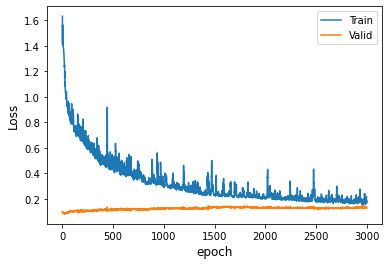

In [19]:
plt.plot(TrainHistory['TrainLoss'], label = "Train")
plt.plot(TrainHistory['ValidLoss'], label = "Valid")
plt.xlabel('epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.show()

### The validation loss  is lower than the training loss. In this case, it indicates that the validation dataset may be easier for the model to predict than the training data set.

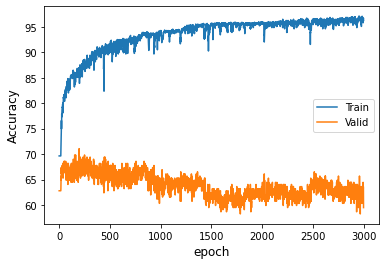

In [20]:
plt.plot(TrainHistory['TrainAcc'], label = "Train")
plt.plot(TrainHistory['ValidAcc'], label = "Valid")
plt.xlabel('epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

plt.show()

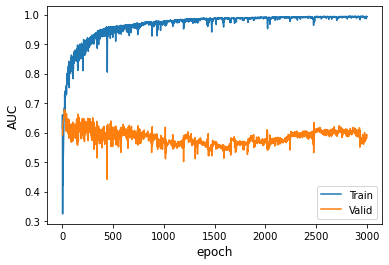

In [21]:
plt.plot(TrainHistory['TrainAUC'], label = "Train")
plt.plot(TrainHistory['ValidAUC'], label = "Valid")
plt.xlabel('epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend()

plt.show()

Study materials: **How to use Learning Curves to Diagnose Machine Learning Model Performance**

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

A plot of learning curves shows **Underfitting** if:
- The training loss remains flat regardless of training;
- The training loss continues to decrease untill the end of training;

A plot of learning curves shows **Overfitting** if:
- The training loss continues to decrease with experience;
- The validation loss decreases to a point and begins increasing again;

A plot of learning curves shows **Goodfitting** if:
- The plot of training loss decreases to a point of stability;
- The plot of validation loss decreases to a point of stability and has a small gap with the training loss;

A plot of learning curves shows **Unrepresentative training set** if:
- The plot of training loss shows improvement;
- The plot of validation loss shows improvement, but a large gap between two curves;

A plot of learning curves shows **Unrepresentative validation set** if:
- The plot of training loss shows goodfit;
- The plot of validation loss shows noisy movement around the training loss;
- The validation loss is lower than the training loss;

# Test set performance

In [22]:
model.eval()

# predicted labels
phylotypetest_input_rnn  = torch.from_numpy(phylotypetest_input).float().to(device)
phylotypetest_output_rnn, hidden = model(phylotypetest_input_rnn)
phylotypetest_output_rnn = phylotypetest_output_rnn.reshape((mytest_output_0.shape))
output_prob = nn.functional.softmax(phylotypetest_output_rnn, dim=2)
mypredprob = output_prob[:,3,0].cpu().detach().numpy()
mypred = 1*(mypredprob > 0.5)

# observed labels
myobs  = mytest_output_0[:,3,0]

In [23]:
confusion = metrics.confusion_matrix(myobs, mypred)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[66 13]
 [22 19]]


In [24]:
specificity = TN / (TN + FP)
print(specificity)
sensitivity = TP / (TP + FN)
print(sensitivity)
precision = TP/(TP + FP)
print(precision)

0.8354430379746836
0.4634146341463415
0.59375


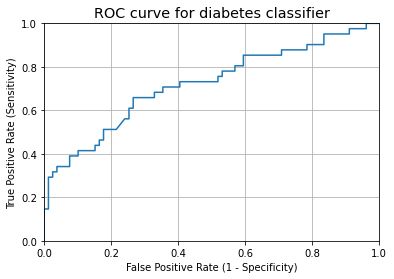

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(myobs, mypredprob)
thresholdData = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds}
thresholdData = pd.DataFrame(thresholdData)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [26]:
print(metrics.roc_auc_score(myobs, mypredprob))

0.7196665637542452


# Additional Questions:

## A1. How to select the best model?

The training steps stop when the mean of validation loss is less than or equal to the mean from last iteration.

In [27]:
# val_losses = []
# valid_loss_min = np.Inf

# # for each epoch
# val_loss = ...
# val_losses.append(val_loss.item())

# if np.mean(val_losses) <= valid_loss_min:
#     torch.save(model.state_dict(), './state_dict.pt')
#     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
#     valid_loss_min = np.mean(val_losses)

## A2. How to do feature scaling (min-max or standard normalization)?